# Evolución del Lenguaje: Palabras más dichas a lo largo del tiempo


Obviamente, las palabras más utilizadas que no estén contenidas dentro de las "stop-words" ya que estas aportan poca info relevante en este aspecto.

## Librerías a utilizar:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.util import ngrams
import re
# nltk.download('punkt')
# nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from collections import Counter


## Datos:

In [2]:
df_scripts = pd.read_csv('The Saimpsons Archive/in_use/simpsons_script_lines.csv')
print(df_scripts.shape)
df_scripts.sample(3)

(158270, 13)


,id,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count
26326,36025,125,123,"Cliff: You see, the kids they listen to the ra...",534000,True,1572.0,1270.0,Cliff,COSBY SHOW LIVING ROOM,"You see, the kids they listen to the rap-music...",you see the kids they listen to the rap-music ...,69.0
82149,92111,319,192,"Krusty the Clown: Oh God, you're canceling me!",831000,True,139.0,408.0,Krusty the Clown,Krusty's House,"Oh God, you're canceling me!",oh god youre canceling me,5.0
94386,104416,364,82,"Lisa Simpson: When Mount Vesuvius erupted, peo...",298000,True,9.0,3013.0,Lisa Simpson,POMPEII,"When Mount Vesuvius erupted, people were overc...",when mount vesuvius erupted people were overco...,28.0


In [3]:
df_ep = pd.read_csv('The Saimpsons Archive/in_use/simpsons_episodes.csv')
df_ep.sample(3)

,id,imdb_rating,imdb_votes,number_in_season,number_in_series,original_air_date,original_air_year,production_code,season,title,us_viewers_in_millions,views
249,40,8.5,1452.0,5,40,1991-10-17,1991,8F04,3,Homer Defined,20.60,50601.0
309,156,8.0,1085.0,3,156,1996-11-10,1996,4F03,8,The Homer They Fall,17.00,61146.0
406,367,7.0,535.0,11,367,2006-01-29,2006,HABF04,17,We're on the Road to D'ohwhere,9.04,43599.0


In [4]:
df_scripts = pd.merge(df_scripts, df_ep[['id', 'season']], left_on='episode_id', right_on='id')
df_scripts.sample(4)

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season
141072,149945,536,106,Bart Simpson: (RAPPING) HEY BIG MAN / DON'T WA...,508000,True,8.0,5.0,Bart Simpson,Simpson Home,HEY BIG MAN / DON'T WANT NO TROUBLE / I'M JUST...,hey big man dont want no trouble im just here ...,16.0,536,25
27544,35064,121,272,Homer Simpson: I have every right to be on tha...,1124000,True,2.0,1225.0,Homer Simpson,Hotel Hallway,I have every right to be on that jury even tho...,i have every right to be on that jury even tho...,23.0,121,6
104810,113896,400,69,(Springfield Dental Complex: EXT. SPRINGFIELD ...,274000,False,NaN,3289.0,NaN,Springfield Dental Complex,NaN,NaN,0.0,400,18
10868,16516,55,49,Bart Simpson: And stress is collecting in the ...,256000,True,8.0,2.0,Bart Simpson,Car,And stress is collecting in the trouble spots ...,and stress is collecting in the trouble spots ...,17.0,55,3


### Mini-tratamiento datos básico

In [5]:
season_group_1 = range(1,11)
season_group_2 = range(11, 20)
season_group_3 = range(20, 29)

In [6]:
df_scripts.loc[df_scripts['season'].isin(season_group_1), 'season_group'] = 1
df_scripts.loc[df_scripts['season'].isin(season_group_2), 'season_group'] = 2
df_scripts.loc[df_scripts['season'].isin(season_group_3), 'season_group'] = 3
df_scripts.sample(2)

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season,season_group
92104,101190,352,25,Lindsay Naegle: These two spokes-rebels were i...,129000,True,3057.0,28.0,Lindsay Naegle,Skinner's Office,These two spokes-rebels were invented by the m...,these two spokes-rebels were invented by the m...,17.0,352,16,2.0
134458,142774,510,75,Homer Simpson: Treasures? Gifts? You got it al...,564000,True,2.0,4097.0,Homer Simpson,ALIEN UNIVERSE,Treasures? Gifts? You got it all wrong. That s...,treasures gifts you got it all wrong that stuf...,13.0,510,24,3.0


## NLP:

In [7]:
df_scripts = df_scripts[df_scripts['speaking_line']==True]
df_scripts['tokenized_spoken_words'] = df_scripts['spoken_words'].apply(nltk.word_tokenize)

In [8]:
def filter_alpha(tokens):
    return [x for x in tokens if x.isalpha()]

def token_lower(tokens):
    return [x.lower() for x in tokens if x.lower() == x ]

def bigram(tokens):
    bigrams = list(ngrams(tokens, 2))
    return bigrams

def trigram(tokens):
    n_grams = list(ngrams(tokens, 3))
    return n_grams

def cuatrigram(tokens):
    n_grams = list(ngrams(tokens, 4))
    return n_grams

def pentagram(tokens):
    n_grams = list(ngrams(tokens, 5))
    return n_grams

lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return [lemmatizer.lemmatize(token) for token in tokens]

In [9]:
df_scripts['tokenized_spoken_words'] = df_scripts['tokenized_spoken_words'].apply(filter_alpha)
df_scripts['tokenized_spoken_words'] = df_scripts['tokenized_spoken_words'].apply(token_lower)
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season,season_group,tokenized_spoken_words
129263,136214,486,3,Seymour Skinner: Please welcome Springfield El...,27000,True,3.0,3.0,Seymour Skinner,Springfield Elementary School,Please welcome Springfield Elementary's own La...,please welcome springfield elementarys own lad...,7.0,486,22,3.0,"[welcome, own]"


In [10]:
df_scripts['lemmatized_text'] = df_scripts['tokenized_spoken_words'].apply(lemmatize_tokens)
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season,season_group,tokenized_spoken_words,lemmatized_text
131928,140240,501,34,Paula Paul: (SIGNING BOX) Uh-huh... (LOOKS UP)...,246000,True,6042.0,4041.0,Paula Paul,Swapper Jack's,"Uh-huh... You know, while I was signing this f...",uh-huh you know while i was signing this for y...,15.0,501,23,3.0,"[know, while, was, signing, this, for, your, w...","[know, while, wa, signing, this, for, your, wi..."


In [11]:
df_scripts['bigrams'] = df_scripts['lemmatized_text'].apply(bigram)
df_scripts['bigrams'] = df_scripts['bigrams'].apply(lambda x: [' '.join(bigram) for bigram in x])
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season,season_group,tokenized_spoken_words,lemmatized_text,bigrams
135452,144057,514,246,"Steve Mobbs: (POINTS TO TABLET) You know, we'v...",1103000,True,5276.0,5.0,Steve Mobbs,Simpson Home,"You know, we've got a new version of that tablet.",you know weve got a new version of that tablet,10.0,514,24,3.0,"[know, we, got, a, new, version, of, that, tab...","[know, we, got, a, new, version, of, that, tab...","[know we, we got, got a, a new, new version, v..."


In [12]:
df_scripts['trigrams'] = df_scripts['lemmatized_text'].apply(trigram)
df_scripts['trigrams'] = df_scripts['trigrams'].apply(lambda x: [' '.join(bigram) for bigram in x])
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,spoken_words,normalized_text,word_count,id_y,season,season_group,tokenized_spoken_words,lemmatized_text,bigrams,trigrams
71189,77803,269,259,Homer Simpson: I liked that story 'cause I was...,1246000,True,2.0,131.0,Homer Simpson,First Church of Springfield,I liked that story 'cause I was a Judge.,i liked that story cause i was a judge,9.0,269,12,2.0,"[liked, that, story, was, a]","[liked, that, story, wa, a]","[liked that, that story, story wa, wa a]","[liked that story, that story wa, story wa a]"


In [13]:
df_scripts['cuatrigrams'] = df_scripts['lemmatized_text'].apply(cuatrigram)
df_scripts['cuatrigrams'] = df_scripts['cuatrigrams'].apply(lambda x: [' '.join(bigram) for bigram in x])
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,normalized_text,word_count,id_y,season,season_group,tokenized_spoken_words,lemmatized_text,bigrams,trigrams,cuatrigrams
143032,153636,551,18,"Gil Gunderson: You know, I used to be the buye...",174000,True,2369.0,381.0,Gil Gunderson,Supermarket,...,you know i used to be the buyer for the whole ...,49.0,551,25,3.0,"[know, used, to, be, the, buyer, for, the, who...","[know, used, to, be, the, buyer, for, the, who...","[know used, used to, to be, be the, the buyer,...","[know used to, used to be, to be the, be the b...","[know used to be, used to be the, to be the bu..."


In [14]:
df_scripts['pentagrams'] = df_scripts['lemmatized_text'].apply(pentagram)
df_scripts['pentagrams'] = df_scripts['pentagrams'].apply(lambda x: [' '.join(bigram) for bigram in x])
df_scripts.sample()

,id_x,episode_id,number,raw_text,timestamp_in_ms,speaking_line,character_id,location_id,raw_character_text,raw_location_text,...,word_count,id_y,season,season_group,tokenized_spoken_words,lemmatized_text,bigrams,trigrams,cuatrigrams,pentagrams
96946,106028,370,12,Rev. Timothy Lovejoy: This fundraiser is close...,74000,True,140.0,3072.0,Rev. Timothy Lovejoy,RIVERSIDE PARK,...,25.0,370,17,2.0,"[fundraiser, is, close, to, achieving, the, go...","[fundraiser, is, close, to, achieving, the, go...","[fundraiser is, is close, close to, to achievi...","[fundraiser is close, is close to, close to ac...","[fundraiser is close to, is close to achieving...","[fundraiser is close to achieving, is close to..."


## N-gramas más habituales a lo largo de la serie

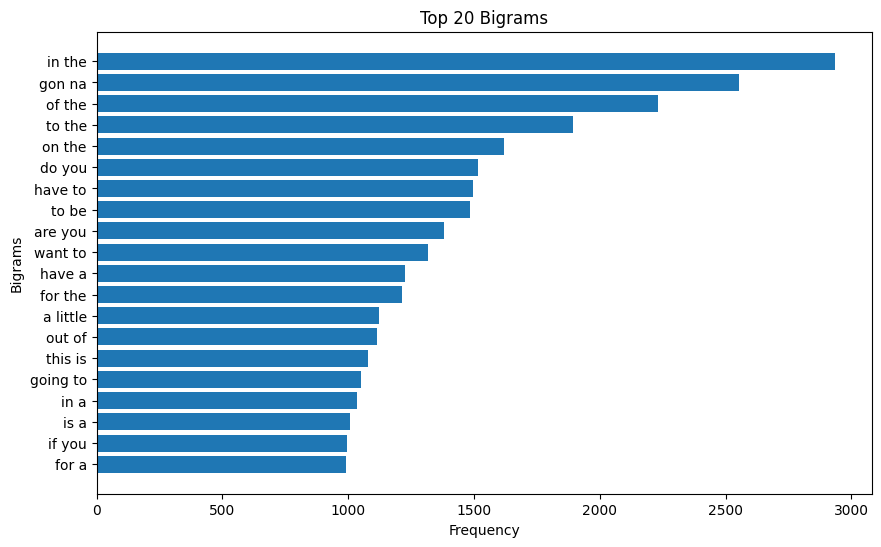

In [15]:
# Flatten the list of lists
all_bigrams = [bigram for sublist in df_scripts['bigrams'] for bigram in sublist]

# Count the occurrences of each bigram
bigram_counts = Counter(all_bigrams)

# Extract the top 20 bigrams
top_bigrams = bigram_counts.most_common(20)

# Extract bigrams and their counts
bigrams, counts = zip(*top_bigrams)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(bigrams)), counts, tick_label=bigrams)
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.title('Top 20 Bigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()


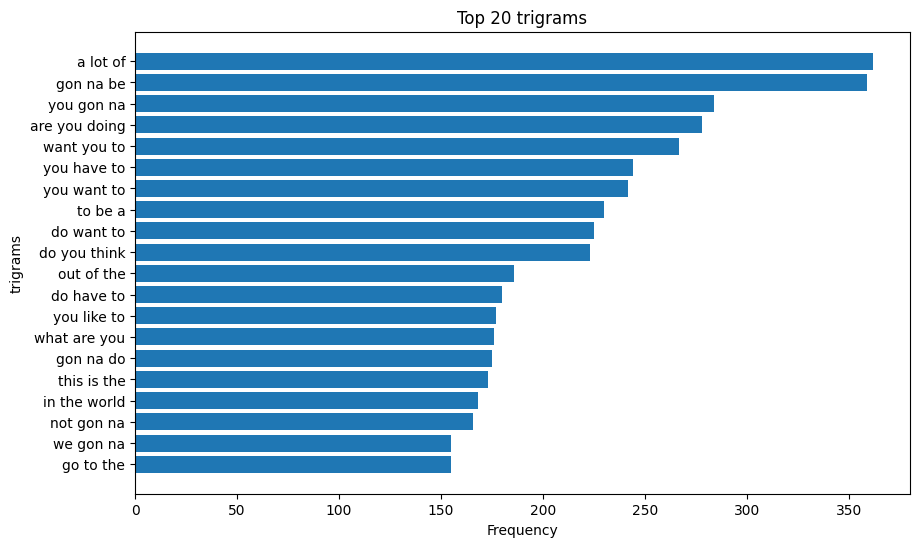

In [16]:
# Flatten the list of lists
all_trigrams = [trigram for sublist in df_scripts['trigrams'] for trigram in sublist]

# Count the occurrences of each trigram
trigram_counts = Counter(all_trigrams)

# Extract the top 20 trigrams
top_trigrams = trigram_counts.most_common(20)

# Extract trigrams and their counts
trigrams, counts = zip(*top_trigrams)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(trigrams)), counts, tick_label=trigrams)
plt.xlabel('Frequency')
plt.ylabel('trigrams')
plt.title('Top 20 trigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()


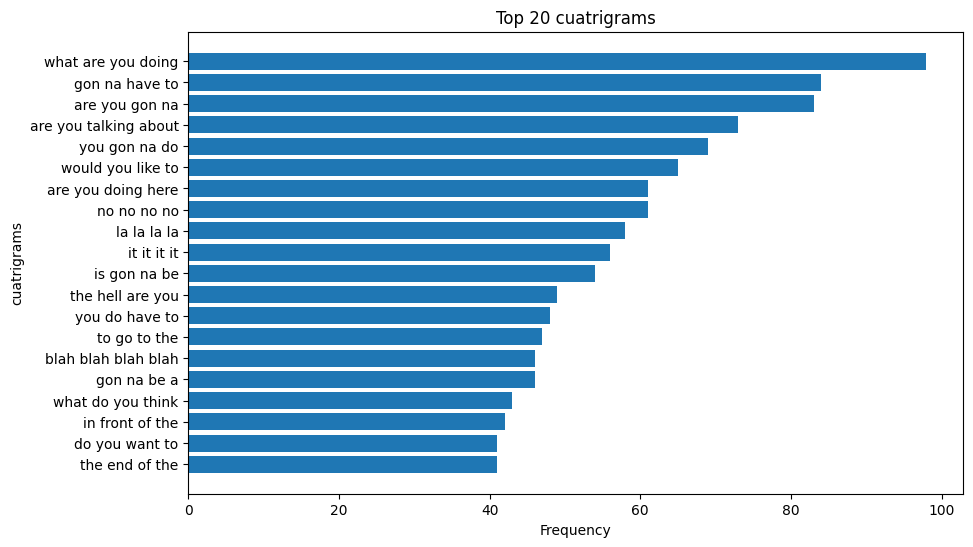

In [17]:
# Flatten the list of lists
all_cuatrigrams = [cuatrigram for sublist in df_scripts['cuatrigrams'] for cuatrigram in sublist]

# Count the occurrences of each cuatrigram
cuatrigram_counts = Counter(all_cuatrigrams)

# Extract the top 20 cuatrigrams
top_cuatrigrams = cuatrigram_counts.most_common(20)

# Extract cuatrigrams and their counts
cuatrigrams, counts = zip(*top_cuatrigrams)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(cuatrigrams)), counts, tick_label=cuatrigrams)
plt.xlabel('Frequency')
plt.ylabel('cuatrigrams')
plt.title('Top 20 cuatrigrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()


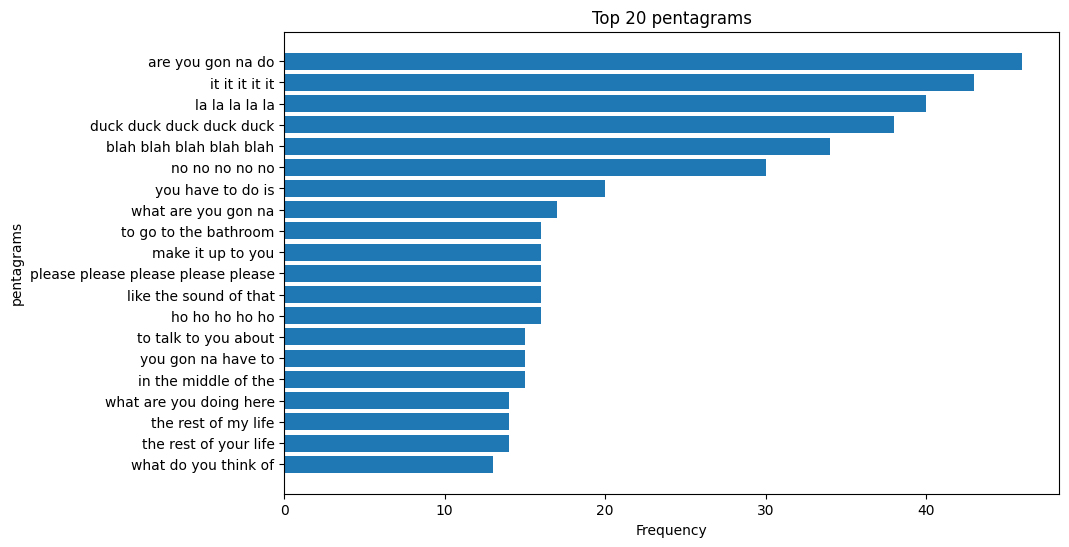

In [18]:
# Flatten the list of lists
all_pentagrams = [pentagram for sublist in df_scripts['pentagrams'] for pentagram in sublist]

# Count the occurrences of each pentagram
pentagram_counts = Counter(all_pentagrams)

# Extract the top 20 pentagrams
top_pentagrams = pentagram_counts.most_common(20)

# Extract pentagrams and their counts
pentagrams, counts = zip(*top_pentagrams)

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(range(len(pentagrams)), counts, tick_label=pentagrams)
plt.xlabel('Frequency')
plt.ylabel('pentagrams')
plt.title('Top 20 pentagrams')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()


### Top ngramas para Homer Simpson

In [19]:
df_scripts_sg1_hs = df_scripts[(df_scripts['season_group'] == 1) & (df_scripts['character_id'] == 2.0)]
df_scripts_sg2_hs = df_scripts[(df_scripts['season_group'] == 2) & (df_scripts['character_id'] == 2.0)]
df_scripts_sg3_hs = df_scripts[(df_scripts['season_group'] == 3) & (df_scripts['character_id'] == 2.0)]

# Grupo temporadas 1
all_bigrams_sg1_hs = [bigram for sublist in df_scripts_sg1_hs['bigrams'] for bigram in sublist]
bigram_counts_sg1_hs = Counter(all_bigrams_sg1_hs)
top_bigrams_sg1_hs = bigram_counts_sg1_hs.most_common(20)
bigrams_sg1_hs, counts_sg1_hs = zip(*top_bigrams_sg1_hs)

# Grupo temporadas 2
all_bigrams_sg2_hs = [bigram for sublist in df_scripts_sg2_hs['bigrams'] for bigram in sublist]
bigram_counts_sg2_hs = Counter(all_bigrams_sg2_hs)
top_bigrams_sg2_hs = bigram_counts_sg2_hs.most_common(20)
bigrams_sg2_hs, counts_sg2_hs = zip(*top_bigrams_sg2_hs)


# Grupo temporadas 3
all_bigrams_sg3_hs = [bigram for sublist in df_scripts_sg3_hs['bigrams'] for bigram in sublist]
bigram_counts_sg3_hs = Counter(all_bigrams_sg3_hs)
top_bigrams_sg3_hs = bigram_counts_sg3_hs.most_common(20)
bigrams_sg3_hs, counts_sg3_hs = zip(*top_bigrams_sg3_hs)


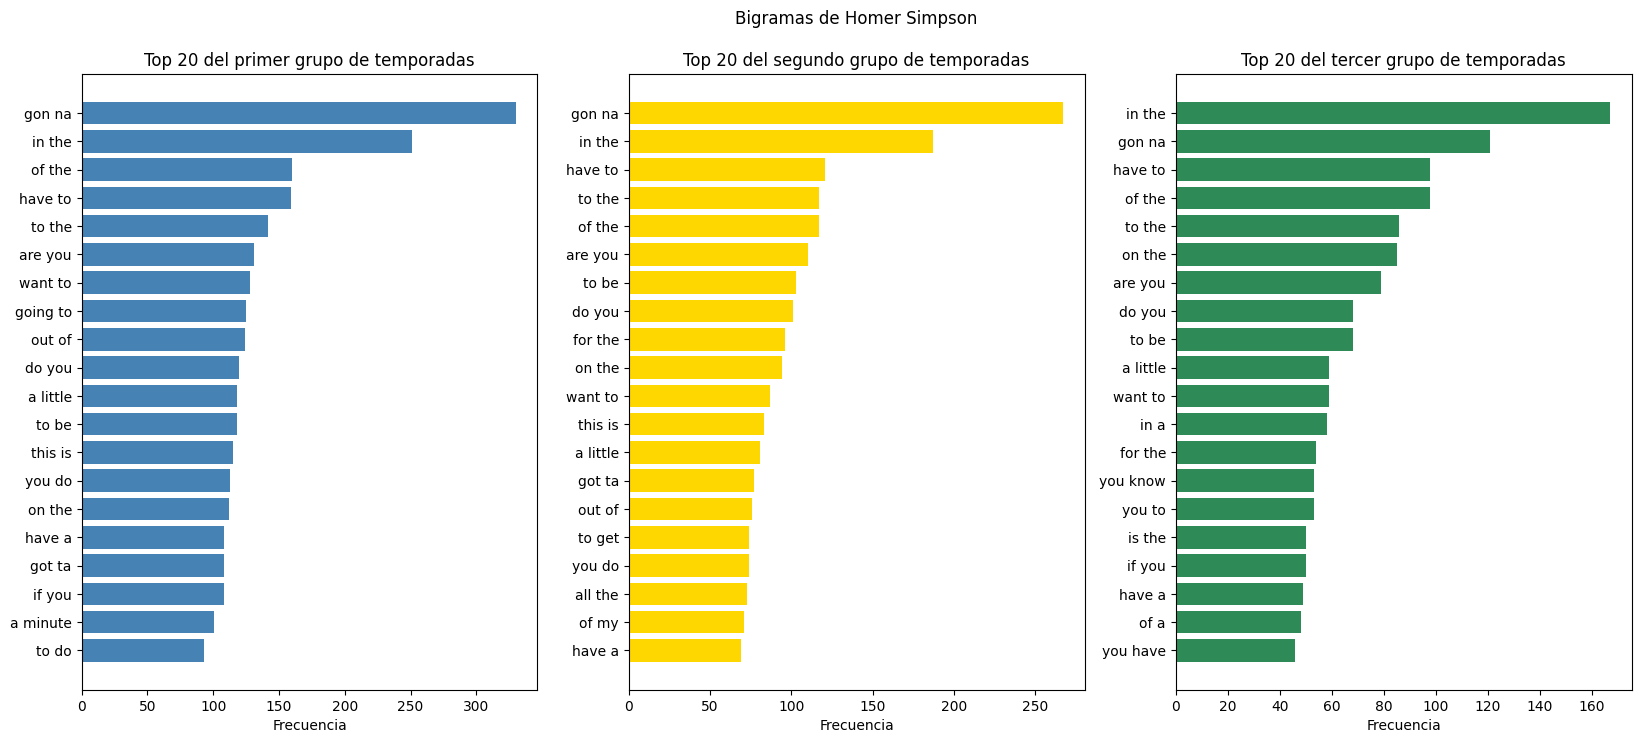

In [20]:
plt.figure(figsize=(20, 8))

plt.title('Bigramas de Homer Simpson\n\n')
plt.axis('off')

plt.subplot(1, 3, 1)
plt.barh(range(len(bigrams_sg1_hs)), counts_sg1_hs, tick_label=bigrams_sg1_hs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.title('Top 20 del primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 2)
plt.barh(range(len(bigrams_sg2_hs)), counts_sg2_hs, tick_label=bigrams_sg2_hs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.title('Top 20 del segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 3)
plt.barh(range(len(bigrams_sg3_hs)), counts_sg3_hs, tick_label=bigrams_sg3_hs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.title('Top 20 del tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [21]:
# Grupo temporadas 1
all_trigrams_sg1_hs = [trigram for sublist in df_scripts_sg1_hs['trigrams'] for trigram in sublist]
trigram_counts_sg1_hs = Counter(all_trigrams_sg1_hs)
top_trigrams_sg1_hs = trigram_counts_sg1_hs.most_common(10)
trigrams_sg1_hs, counts_sg1_hs = zip(*top_trigrams_sg1_hs)

# Grupo temporadas 2
all_trigrams_sg2_hs = [trigram for sublist in df_scripts_sg2_hs['trigrams'] for trigram in sublist]
trigram_counts_sg2_hs = Counter(all_trigrams_sg2_hs)
top_trigrams_sg2_hs = trigram_counts_sg2_hs.most_common(10)
trigrams_sg2_hs, counts_sg2_hs = zip(*top_trigrams_sg2_hs)


# Grupo temporadas 3
all_trigrams_sg3_hs = [trigram for sublist in df_scripts_sg3_hs['trigrams'] for trigram in sublist]
trigram_counts_sg3_hs = Counter(all_trigrams_sg3_hs)
top_trigrams_sg3_hs = trigram_counts_sg3_hs.most_common(10)
trigrams_sg3_hs, counts_sg3_hs = zip(*top_trigrams_sg3_hs)


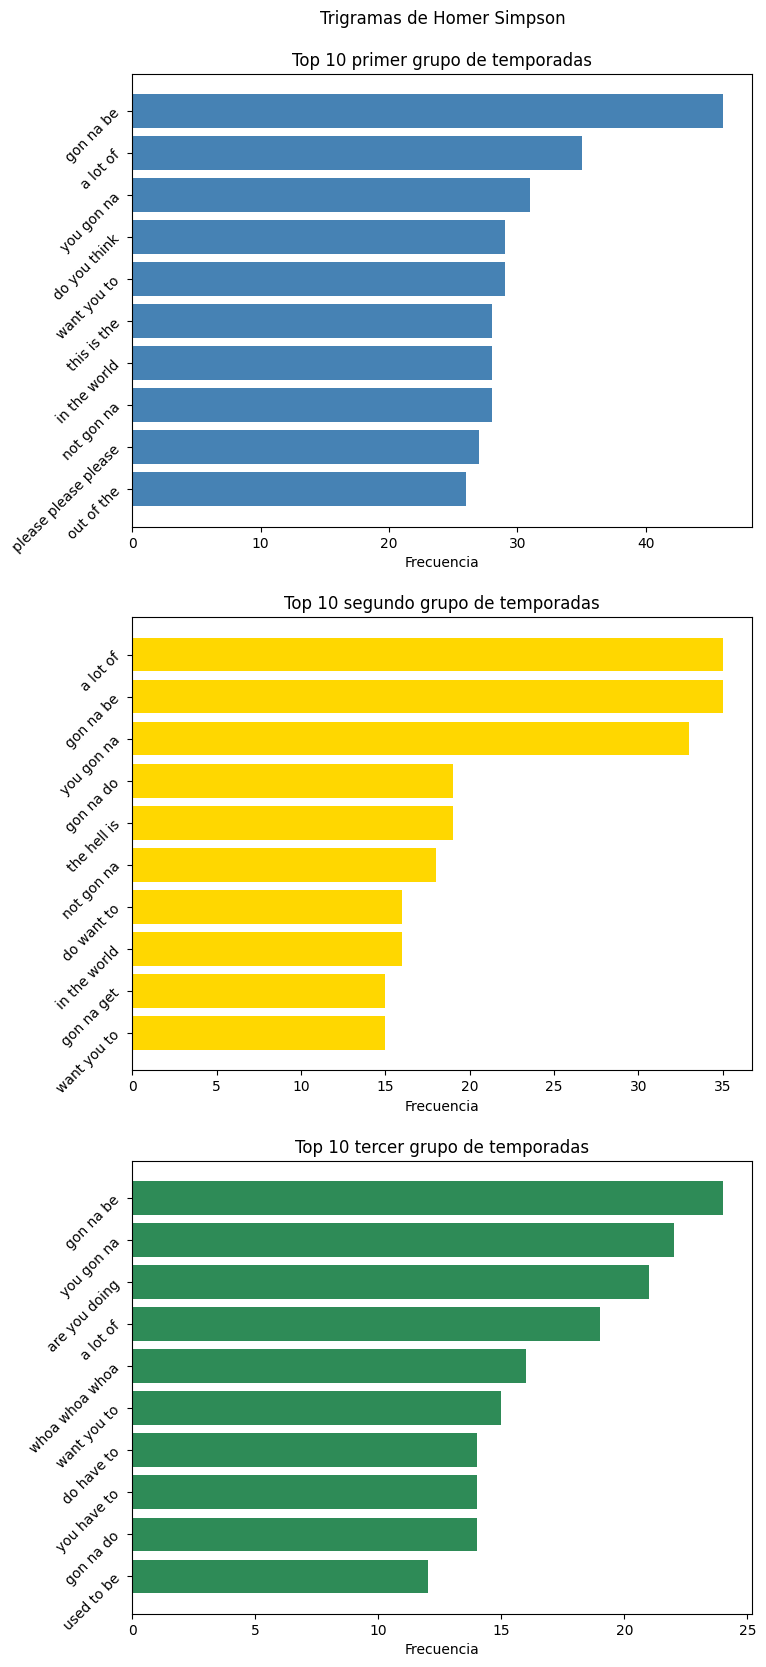

In [22]:
plt.figure(figsize=(8, 20))

plt.title('Trigramas de Homer Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(trigrams_sg1_hs)), counts_sg1_hs, tick_label=trigrams_sg1_hs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(trigrams_sg2_hs)), counts_sg2_hs, tick_label=trigrams_sg2_hs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(trigrams_sg3_hs)), counts_sg3_hs, tick_label=trigrams_sg3_hs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [23]:
# Grupo temporadas 1
all_cuatrigrams_sg1_hs = [cuatrigram for sublist in df_scripts_sg1_hs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg1_hs = Counter(all_cuatrigrams_sg1_hs)
top_cuatrigrams_sg1_hs = cuatrigram_counts_sg1_hs.most_common(10)
cuatrigrams_sg1_hs, counts_sg1_hs = zip(*top_cuatrigrams_sg1_hs)

# Grupo temporadas 2
all_cuatrigrams_sg2_hs = [cuatrigram for sublist in df_scripts_sg2_hs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg2_hs = Counter(all_cuatrigrams_sg2_hs)
top_cuatrigrams_sg2_hs = cuatrigram_counts_sg2_hs.most_common(10)
cuatrigrams_sg2_hs, counts_sg2_hs = zip(*top_cuatrigrams_sg2_hs)


# Grupo temporadas 3
all_cuatrigrams_sg3_hs = [cuatrigram for sublist in df_scripts_sg3_hs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg3_hs = Counter(all_cuatrigrams_sg3_hs)
top_cuatrigrams_sg3_hs = cuatrigram_counts_sg3_hs.most_common(10)
cuatrigrams_sg3_hs, counts_sg3_hs = zip(*top_cuatrigrams_sg3_hs)


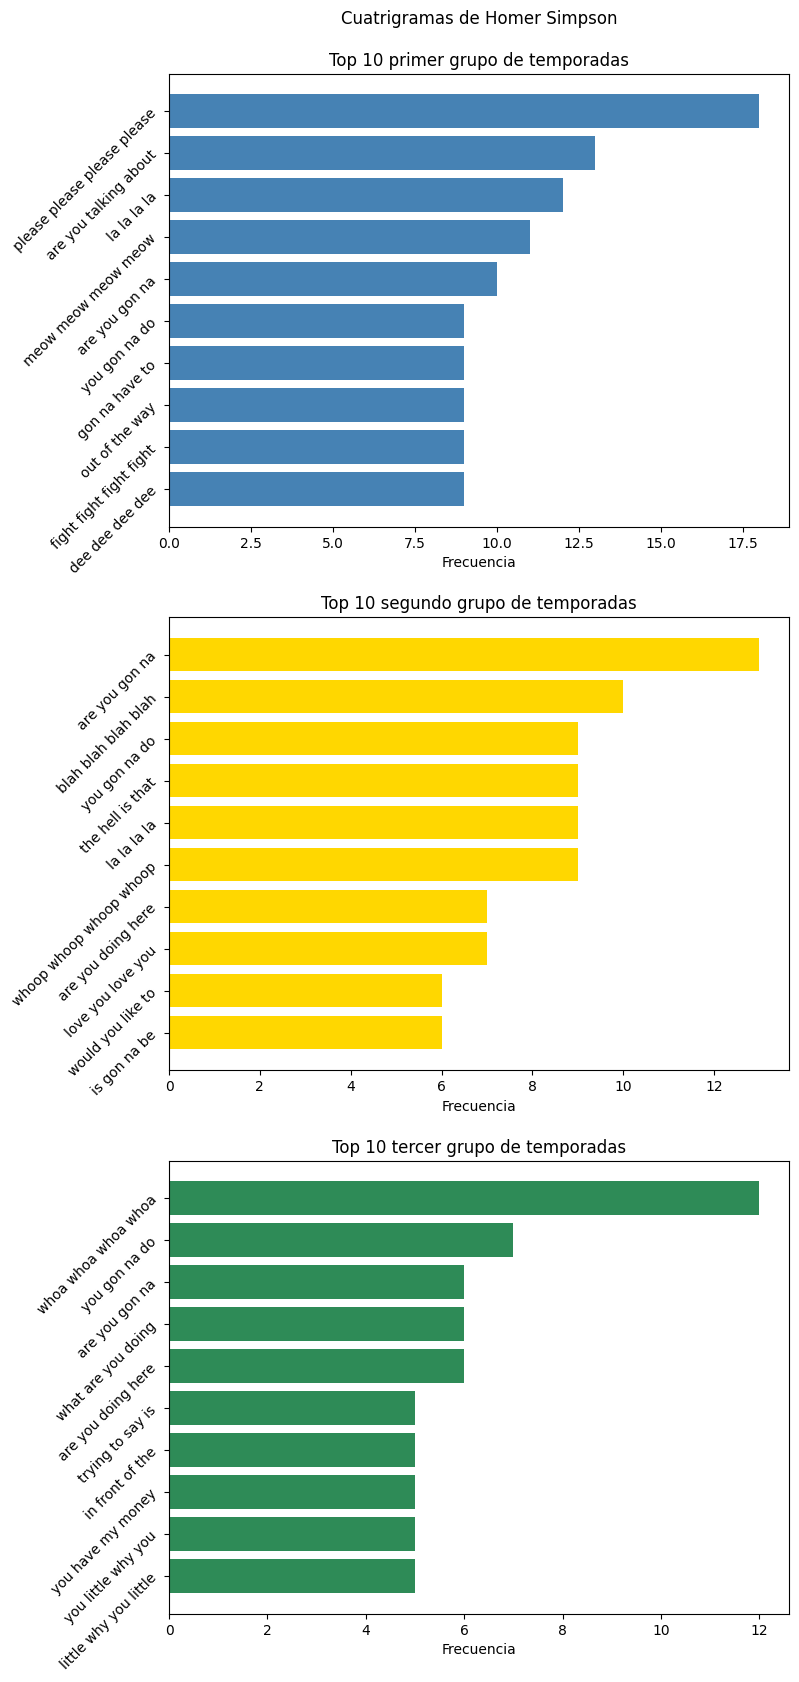

In [24]:
plt.figure(figsize=(8, 20))

plt.title('Cuatrigramas de Homer Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(cuatrigrams_sg1_hs)), counts_sg1_hs, tick_label=cuatrigrams_sg1_hs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(cuatrigrams_sg2_hs)), counts_sg2_hs, tick_label=cuatrigrams_sg2_hs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(cuatrigrams_sg3_hs)), counts_sg3_hs, tick_label=cuatrigrams_sg3_hs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [25]:
# Grupo temporadas 1
all_pentagrams_sg1_hs = [pentagram for sublist in df_scripts_sg1_hs['pentagrams'] for pentagram in sublist]
pentagram_counts_sg1_hs = Counter(all_pentagrams_sg1_hs)
top_pentagrams_sg1_hs = pentagram_counts_sg1_hs.most_common(10)
pentagrams_sg1_hs, counts_sg1_hs = zip(*top_pentagrams_sg1_hs)

# Grupo temporadas 2
all_pentagrams_sg2_hs = [pentagram for sublist in df_scripts_sg2_hs['pentagrams'] for pentagram in sublist]
pentagram_counts_sg2_hs = Counter(all_pentagrams_sg2_hs)
top_pentagrams_sg2_hs = pentagram_counts_sg2_hs.most_common(10)
pentagrams_sg2_hs, counts_sg2_hs = zip(*top_pentagrams_sg2_hs)


# Grupo temporadas 3
all_pentagrams_sg3_hs = [pentagram for sublist in df_scripts_sg3_hs['pentagrams'] for pentagram in sublist]
pentagram_counts_sg3_hs = Counter(all_pentagrams_sg3_hs)
top_pentagrams_sg3_hs = pentagram_counts_sg3_hs.most_common(10)
pentagrams_sg3_hs, counts_sg3_hs = zip(*top_pentagrams_sg3_hs)


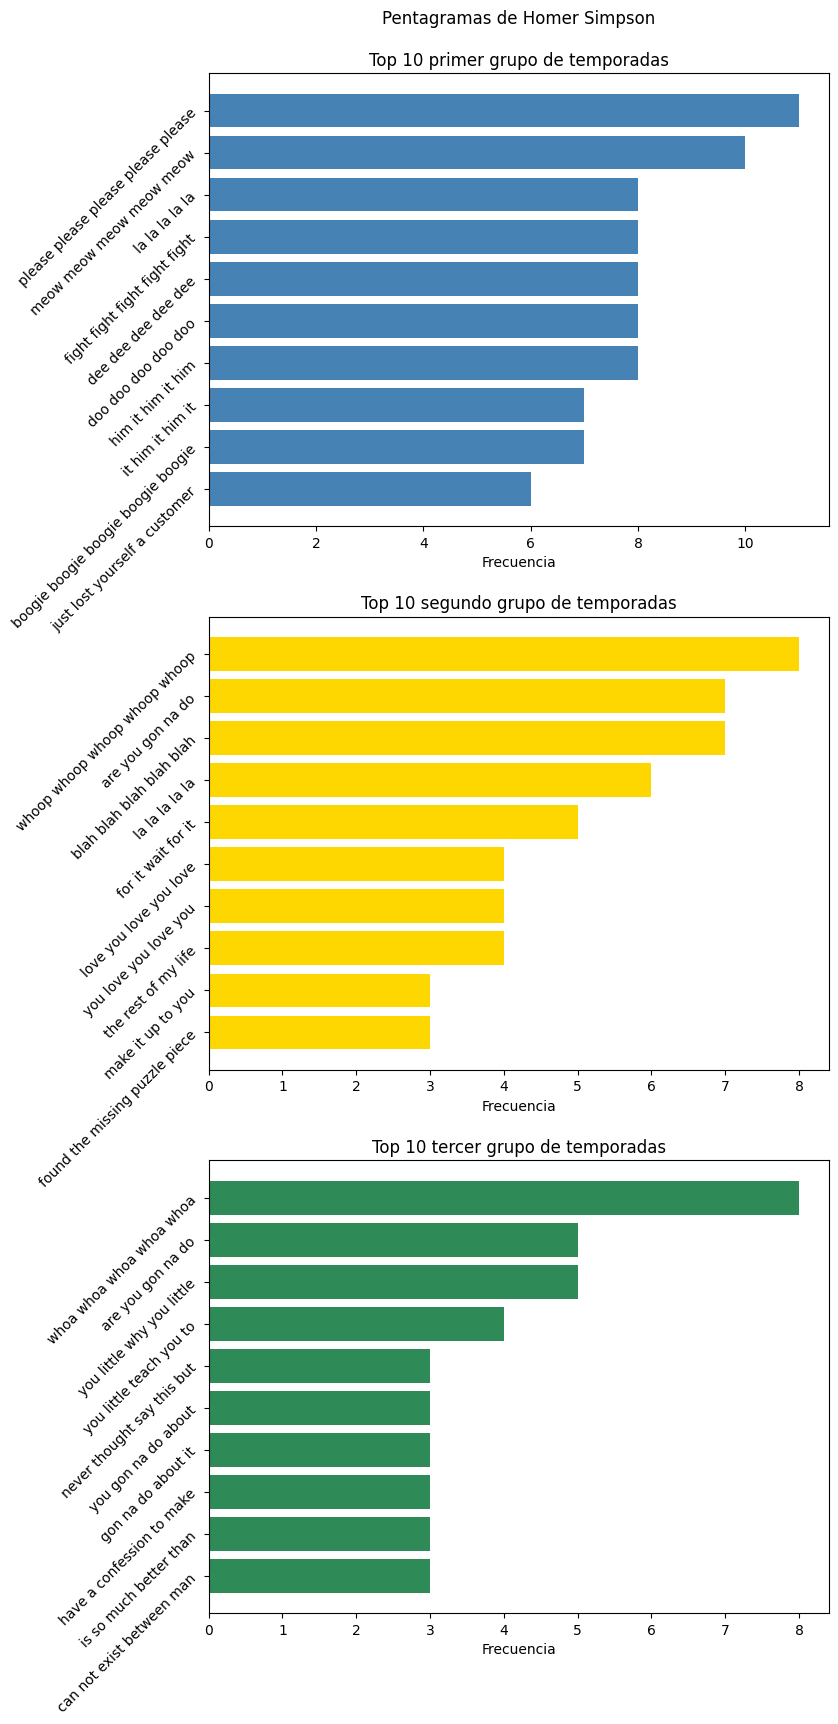

In [26]:
plt.figure(figsize=(8, 20))

plt.title('Pentagramas de Homer Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(pentagrams_sg1_hs)), counts_sg1_hs, tick_label=pentagrams_sg1_hs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(pentagrams_sg2_hs)), counts_sg2_hs, tick_label=pentagrams_sg2_hs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(pentagrams_sg3_hs)), counts_sg3_hs, tick_label=pentagrams_sg3_hs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

### Para Marge Simpson

In [27]:
df_scripts_sg1_ms = df_scripts[(df_scripts['season_group'] == 1) & (df_scripts['character_id'] == 1.0)]
df_scripts_sg2_ms = df_scripts[(df_scripts['season_group'] == 2) & (df_scripts['character_id'] == 1.0)]
df_scripts_sg3_ms = df_scripts[(df_scripts['season_group'] == 3) & (df_scripts['character_id'] == 1.0)]

# Grupo temporadas 1
all_bigrams_sg1_ms = [bigram for sublist in df_scripts_sg1_ms['bigrams'] for bigram in sublist]
bigram_counts_sg1_ms = Counter(all_bigrams_sg1_ms)
top_bigrams_sg1_ms = bigram_counts_sg1_ms.most_common(20)
bigrams_sg1_ms, counts_sg1_ms = zip(*top_bigrams_sg1_ms)

# Grupo temporadas 2
all_bigrams_sg2_ms = [bigram for sublist in df_scripts_sg2_ms['bigrams'] for bigram in sublist]
bigram_counts_sg2_ms = Counter(all_bigrams_sg2_ms)
top_bigrams_sg2_ms = bigram_counts_sg2_ms.most_common(20)
bigrams_sg2_ms, counts_sg2_ms = zip(*top_bigrams_sg2_ms)


# Grupo temporadas 3
all_bigrams_sg3_ms = [bigram for sublist in df_scripts_sg3_ms['bigrams'] for bigram in sublist]
bigram_counts_sg3_ms = Counter(all_bigrams_sg3_ms)
top_bigrams_sg3_ms = bigram_counts_sg3_ms.most_common(20)
bigrams_sg3_ms, counts_sg3_ms = zip(*top_bigrams_sg3_ms)


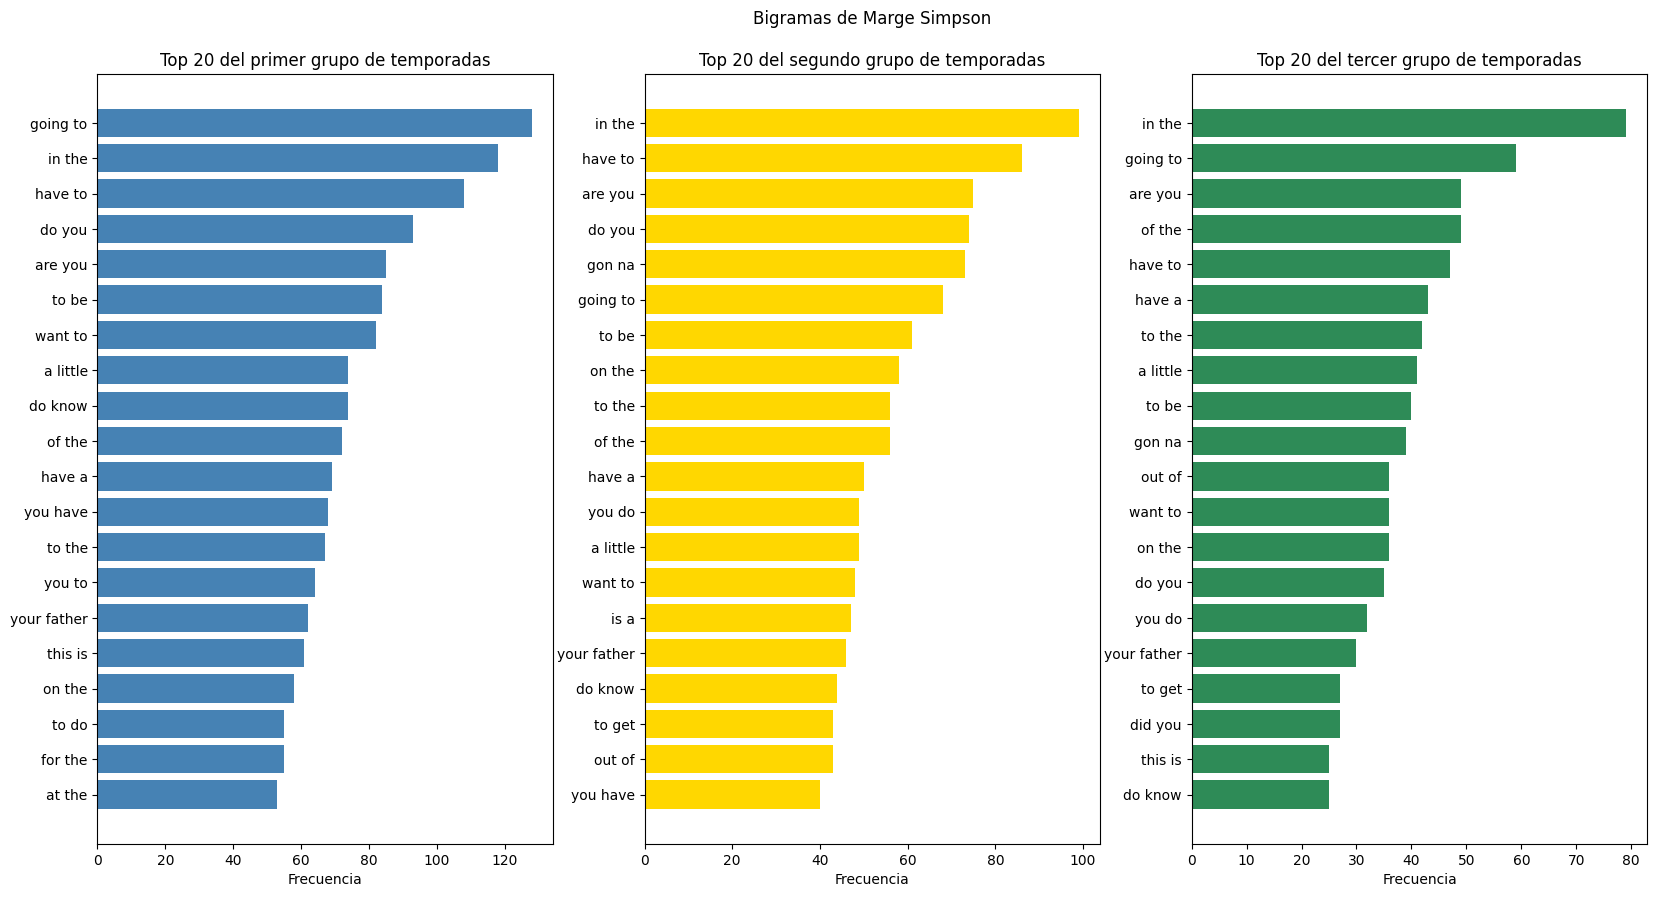

In [28]:
plt.figure(figsize=(20, 10))

plt.title('Bigramas de Marge Simpson\n\n')
plt.axis('off')

plt.subplot(1, 3, 1)
plt.barh(range(len(bigrams_sg1_ms)), counts_sg1_ms, tick_label=bigrams_sg1_ms, color='#4682B4')
plt.xlabel('Frecuencia')
plt.title('Top 20 del primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 2)
plt.barh(range(len(bigrams_sg2_ms)), counts_sg2_ms, tick_label=bigrams_sg2_ms, color='#FFD700')
plt.xlabel('Frecuencia')
plt.title('Top 20 del segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 3)
plt.barh(range(len(bigrams_sg3_ms)), counts_sg3_ms, tick_label=bigrams_sg3_ms, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.title('Top 20 del tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [29]:
# Grupo temporadas 1
all_trigrams_sg1_ms = [trigram for sublist in df_scripts_sg1_ms['trigrams'] for trigram in sublist]
trigram_counts_sg1_ms = Counter(all_trigrams_sg1_ms)
top_trigrams_sg1_ms = trigram_counts_sg1_ms.most_common(10)
trigrams_sg1_ms, counts_sg1_ms = zip(*top_trigrams_sg1_ms)

# Grupo temporadas 2
all_trigrams_sg2_ms = [trigram for sublist in df_scripts_sg2_ms['trigrams'] for trigram in sublist]
trigram_counts_sg2_ms = Counter(all_trigrams_sg2_ms)
top_trigrams_sg2_ms = trigram_counts_sg2_ms.most_common(10)
trigrams_sg2_ms, counts_sg2_ms = zip(*top_trigrams_sg2_ms)


# Grupo temporadas 3
all_trigrams_sg3_ms = [trigram for sublist in df_scripts_sg3_ms['trigrams'] for trigram in sublist]
trigram_counts_sg3_ms = Counter(all_trigrams_sg3_ms)
top_trigrams_sg3_ms = trigram_counts_sg3_ms.most_common(10)
trigrams_sg3_ms, counts_sg3_ms = zip(*top_trigrams_sg3_ms)


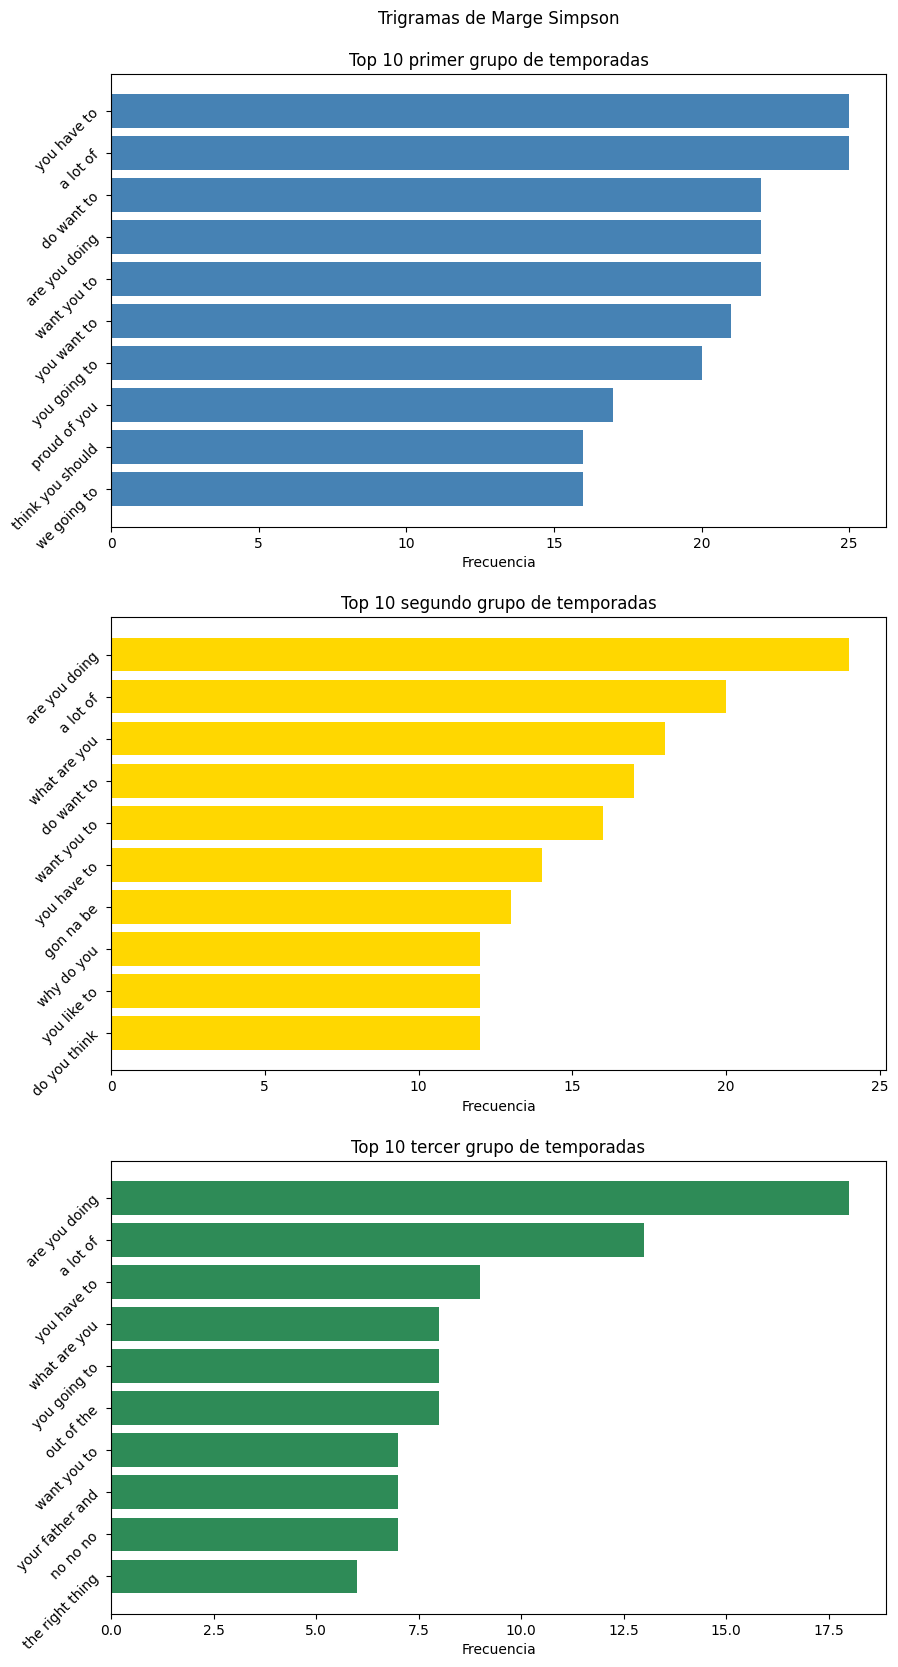

In [30]:
plt.figure(figsize=(10, 20))

plt.title('Trigramas de Marge Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(trigrams_sg1_ms)), counts_sg1_ms, tick_label=trigrams_sg1_ms, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(trigrams_sg2_ms)), counts_sg2_ms, tick_label=trigrams_sg2_ms, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(trigrams_sg3_ms)), counts_sg3_ms, tick_label=trigrams_sg3_ms, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [31]:
# Grupo temporadas 1
all_cuatrigrams_sg1_ms = [cuatrigram for sublist in df_scripts_sg1_ms['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg1_ms = Counter(all_cuatrigrams_sg1_ms)
top_cuatrigrams_sg1_ms = cuatrigram_counts_sg1_ms.most_common(10)
cuatrigrams_sg1_ms, counts_sg1_ms = zip(*top_cuatrigrams_sg1_ms)

# Grupo temporadas 2
all_cuatrigrams_sg2_ms = [cuatrigram for sublist in df_scripts_sg2_ms['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg2_ms = Counter(all_cuatrigrams_sg2_ms)
top_cuatrigrams_sg2_ms = cuatrigram_counts_sg2_ms.most_common(10)
cuatrigrams_sg2_ms, counts_sg2_ms = zip(*top_cuatrigrams_sg2_ms)


# Grupo temporadas 3
all_cuatrigrams_sg3_ms = [cuatrigram for sublist in df_scripts_sg3_ms['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg3_ms = Counter(all_cuatrigrams_sg3_ms)
top_cuatrigrams_sg3_ms = cuatrigram_counts_sg3_ms.most_common(10)
cuatrigrams_sg3_ms, counts_sg3_ms = zip(*top_cuatrigrams_sg3_ms)


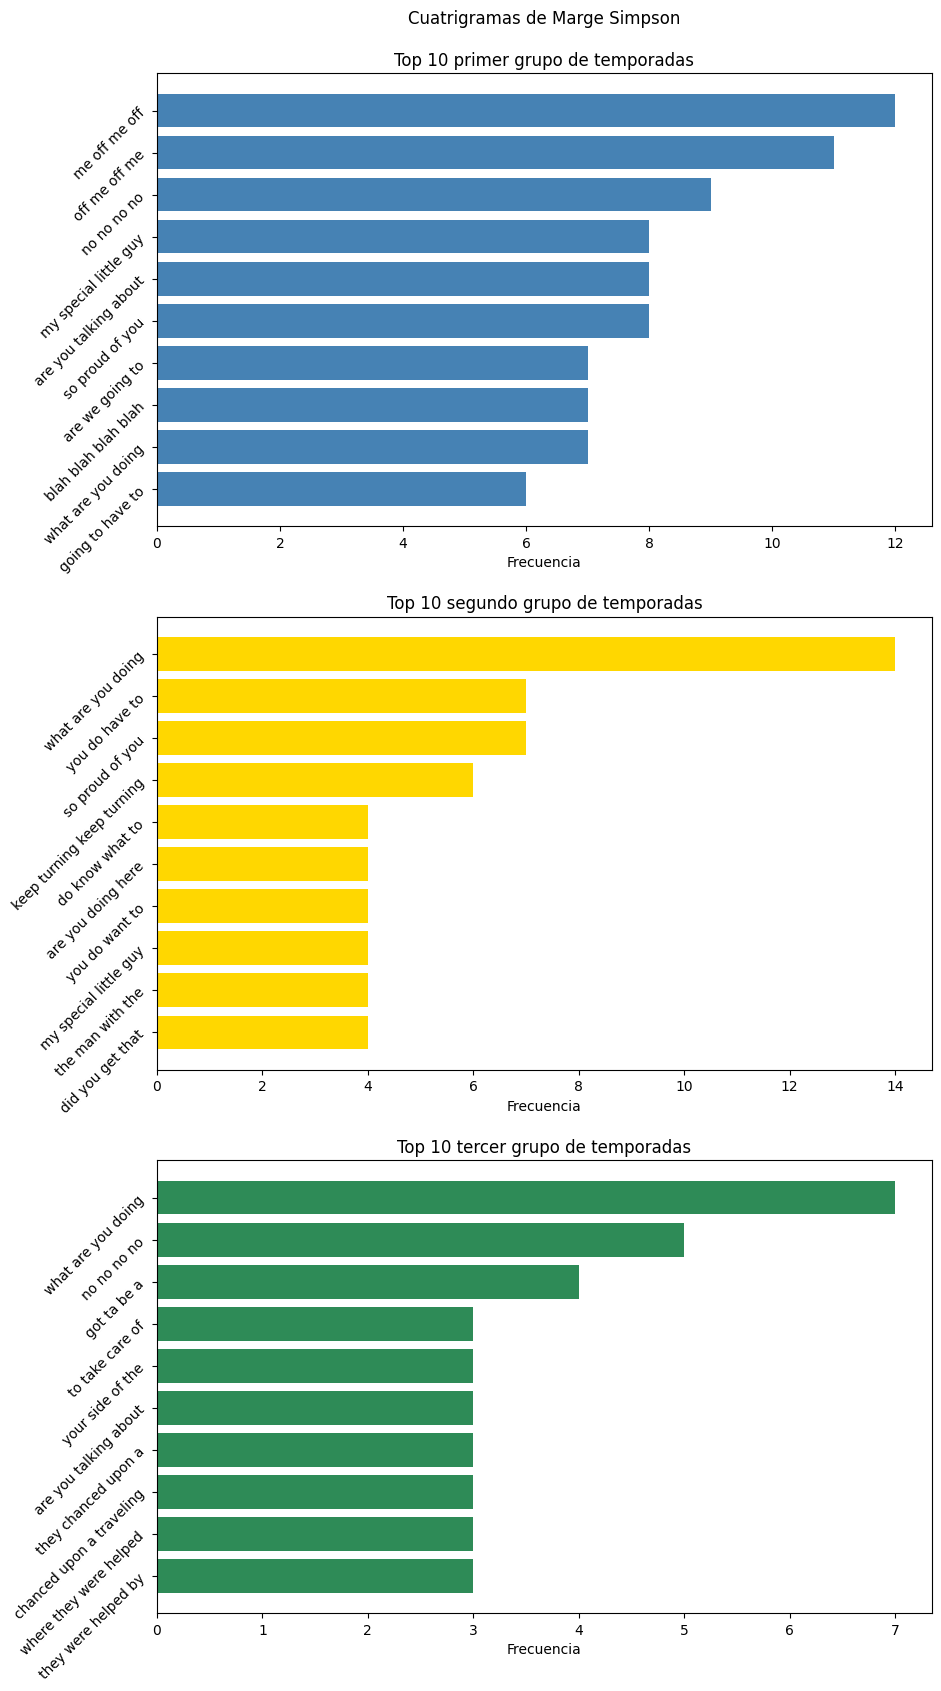

In [32]:
plt.figure(figsize=(10, 20))

plt.title('Cuatrigramas de Marge Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(cuatrigrams_sg1_ms)), counts_sg1_ms, tick_label=cuatrigrams_sg1_ms, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(cuatrigrams_sg2_ms)), counts_sg2_ms, tick_label=cuatrigrams_sg2_ms, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(cuatrigrams_sg3_ms)), counts_sg3_ms, tick_label=cuatrigrams_sg3_ms, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

### Para Bart Simpson

In [33]:
df_scripts_sg1_bs = df_scripts[(df_scripts['season_group'] == 1) & (df_scripts['character_id'] == 8.0)]
df_scripts_sg2_bs = df_scripts[(df_scripts['season_group'] == 2) & (df_scripts['character_id'] == 8.0)]
df_scripts_sg3_bs = df_scripts[(df_scripts['season_group'] == 3) & (df_scripts['character_id'] == 8.0)]

# Grupo temporadas 1
all_bigrams_sg1_bs = [bigram for sublist in df_scripts_sg1_bs['bigrams'] for bigram in sublist]
bigram_counts_sg1_bs = Counter(all_bigrams_sg1_bs)
top_bigrams_sg1_bs = bigram_counts_sg1_bs.most_common(20)
bigrams_sg1_bs, counts_sg1_bs = zip(*top_bigrams_sg1_bs)

# Grupo temporadas 2
all_bigrams_sg2_bs = [bigram for sublist in df_scripts_sg2_bs['bigrams'] for bigram in sublist]
bigram_counts_sg2_bs = Counter(all_bigrams_sg2_bs)
top_bigrams_sg2_bs = bigram_counts_sg2_bs.most_common(20)
bigrams_sg2_bs, counts_sg2_bs = zip(*top_bigrams_sg2_bs)


# Grupo temporadas 3
all_bigrams_sg3_bs = [bigram for sublist in df_scripts_sg3_bs['bigrams'] for bigram in sublist]
bigram_counts_sg3_bs = Counter(all_bigrams_sg3_bs)
top_bigrams_sg3_bs = bigram_counts_sg3_bs.most_common(20)
bigrams_sg3_bs, counts_sg3_bs = zip(*top_bigrams_sg3_bs)


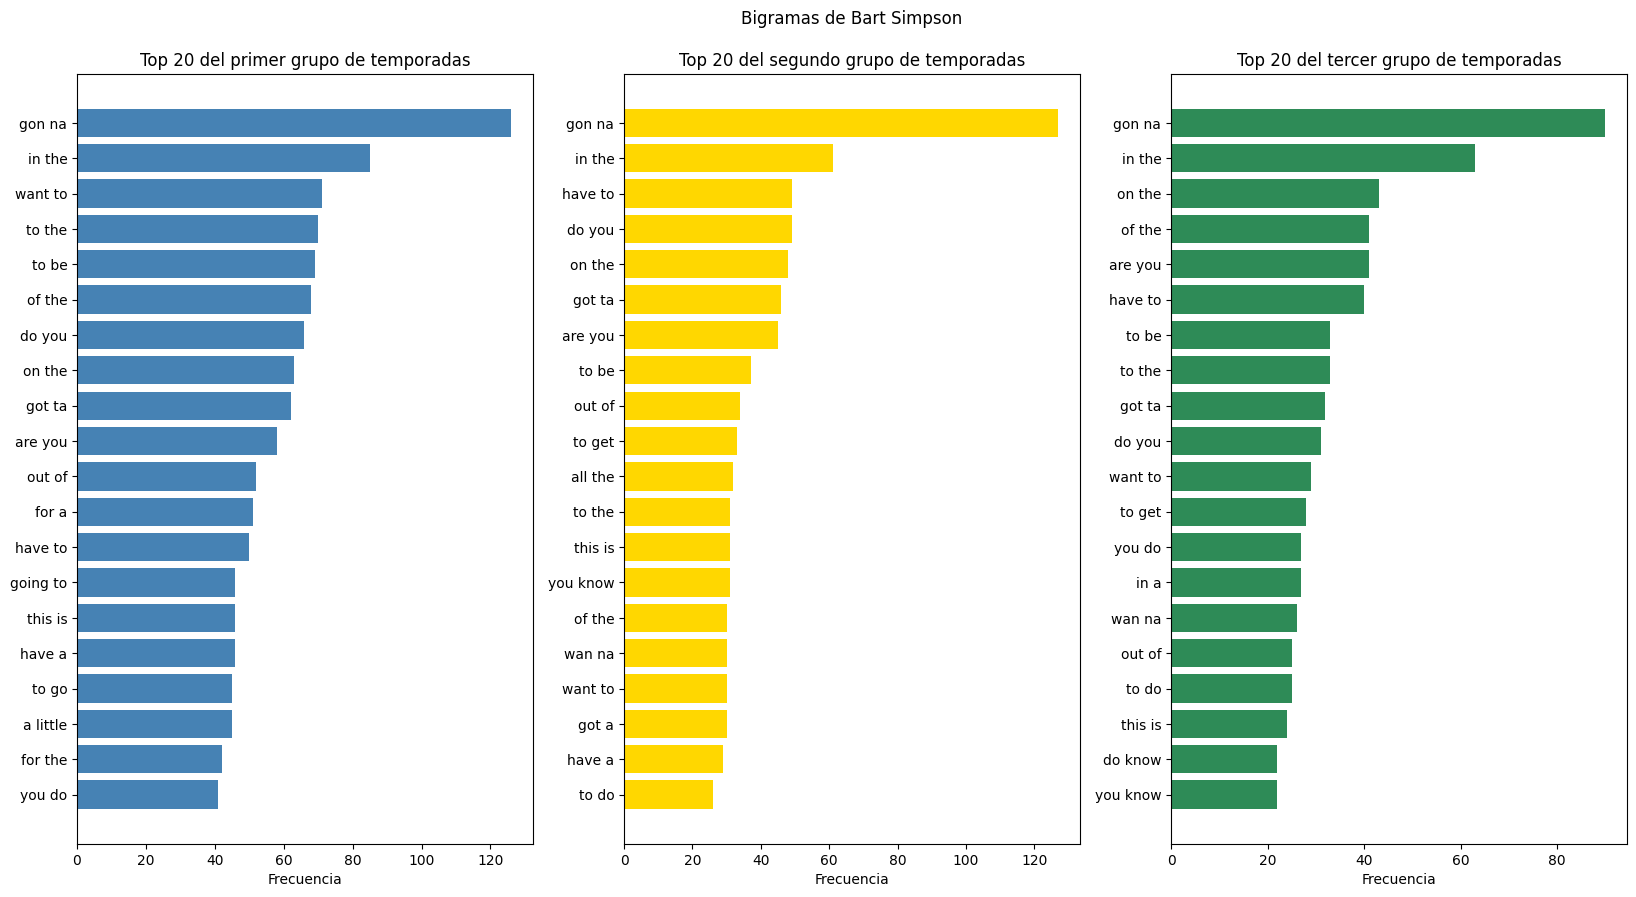

In [34]:
plt.figure(figsize=(20, 10))

plt.title('Bigramas de Bart Simpson\n\n')
plt.axis('off')

plt.subplot(1, 3, 1)
plt.barh(range(len(bigrams_sg1_bs)), counts_sg1_bs, tick_label=bigrams_sg1_bs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.title('Top 20 del primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 2)
plt.barh(range(len(bigrams_sg2_bs)), counts_sg2_bs, tick_label=bigrams_sg2_bs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.title('Top 20 del segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 3)
plt.barh(range(len(bigrams_sg3_bs)), counts_sg3_bs, tick_label=bigrams_sg3_bs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.title('Top 20 del tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [35]:
# Grupo temporadas 1
all_trigrams_sg1_bs = [trigram for sublist in df_scripts_sg1_bs['trigrams'] for trigram in sublist]
trigram_counts_sg1_bs = Counter(all_trigrams_sg1_bs)
top_trigrams_sg1_bs = trigram_counts_sg1_bs.most_common(10)
trigrams_sg1_bs, counts_sg1_bs = zip(*top_trigrams_sg1_bs)

# Grupo temporadas 2
all_trigrams_sg2_bs = [trigram for sublist in df_scripts_sg2_bs['trigrams'] for trigram in sublist]
trigram_counts_sg2_bs = Counter(all_trigrams_sg2_bs)
top_trigrams_sg2_bs = trigram_counts_sg2_bs.most_common(10)
trigrams_sg2_bs, counts_sg2_bs = zip(*top_trigrams_sg2_bs)


# Grupo temporadas 3
all_trigrams_sg3_bs = [trigram for sublist in df_scripts_sg3_bs['trigrams'] for trigram in sublist]
trigram_counts_sg3_bs = Counter(all_trigrams_sg3_bs)
top_trigrams_sg3_bs = trigram_counts_sg3_bs.most_common(10)
trigrams_sg3_bs, counts_sg3_bs = zip(*top_trigrams_sg3_bs)


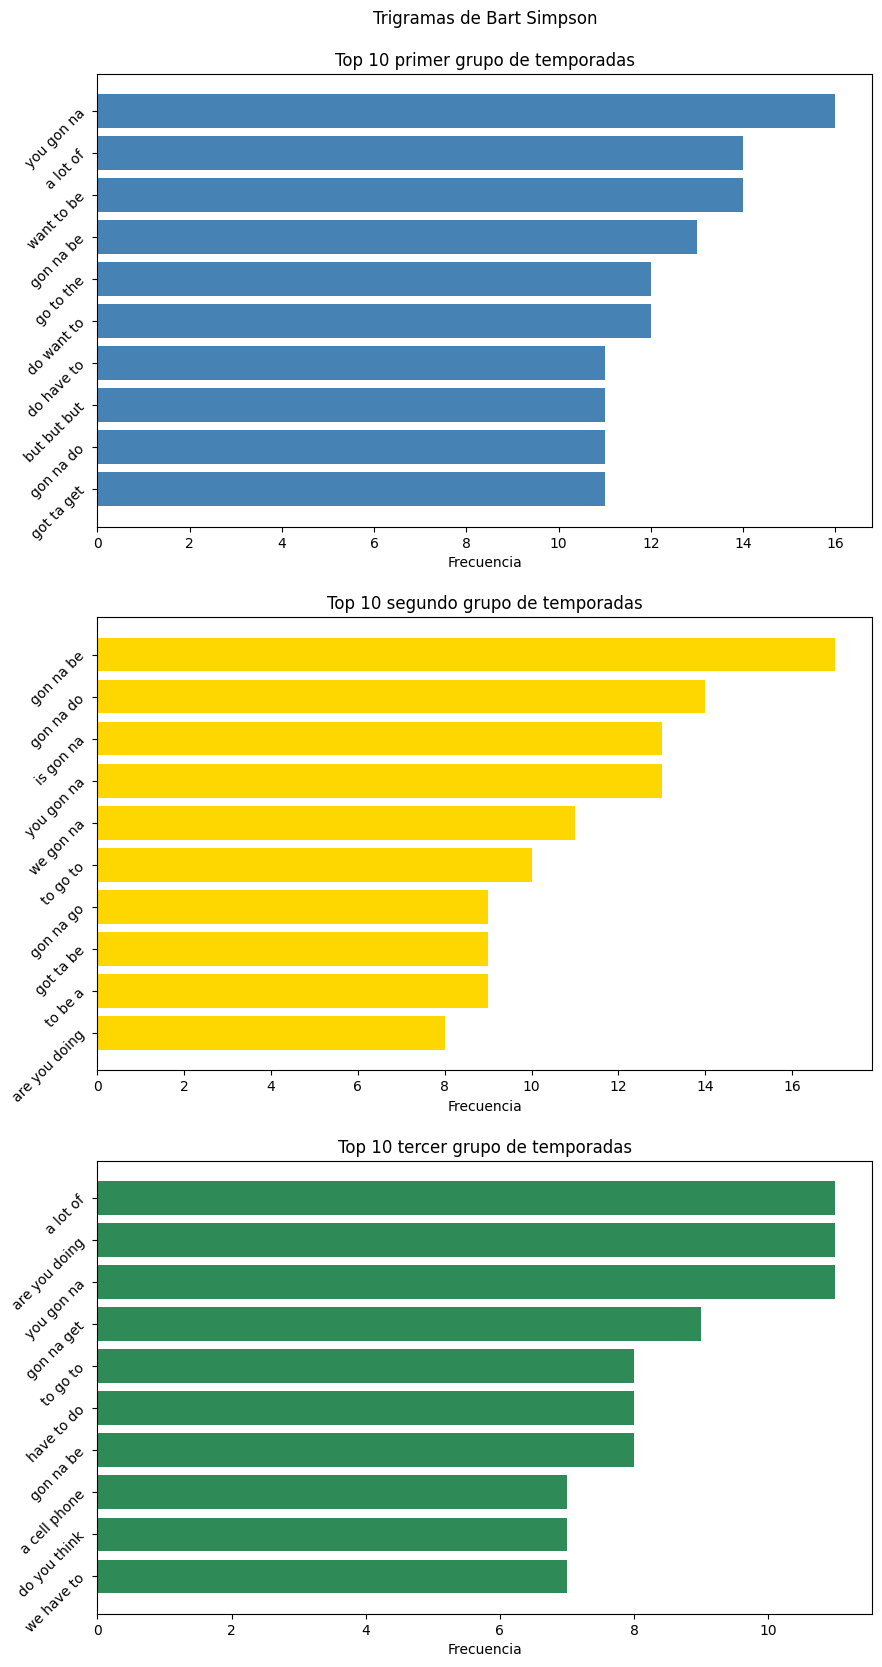

In [36]:
plt.figure(figsize=(10, 20))

plt.title('Trigramas de Bart Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(trigrams_sg1_bs)), counts_sg1_bs, tick_label=trigrams_sg1_bs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(trigrams_sg2_bs)), counts_sg2_bs, tick_label=trigrams_sg2_bs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(trigrams_sg3_bs)), counts_sg3_bs, tick_label=trigrams_sg3_bs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [37]:
# Grupo temporadas 1
all_cuatrigrams_sg1_bs = [cuatrigram for sublist in df_scripts_sg1_bs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg1_bs = Counter(all_cuatrigrams_sg1_bs)
top_cuatrigrams_sg1_bs = cuatrigram_counts_sg1_bs.most_common(10)
cuatrigrams_sg1_bs, counts_sg1_bs = zip(*top_cuatrigrams_sg1_bs)

# Grupo temporadas 2
all_cuatrigrams_sg2_bs = [cuatrigram for sublist in df_scripts_sg2_bs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg2_bs = Counter(all_cuatrigrams_sg2_bs)
top_cuatrigrams_sg2_bs = cuatrigram_counts_sg2_bs.most_common(10)
cuatrigrams_sg2_bs, counts_sg2_bs = zip(*top_cuatrigrams_sg2_bs)


# Grupo temporadas 3
all_cuatrigrams_sg3_bs = [cuatrigram for sublist in df_scripts_sg3_bs['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg3_bs = Counter(all_cuatrigrams_sg3_bs)
top_cuatrigrams_sg3_bs = cuatrigram_counts_sg3_bs.most_common(10)
cuatrigrams_sg3_bs, counts_sg3_bs = zip(*top_cuatrigrams_sg3_bs)


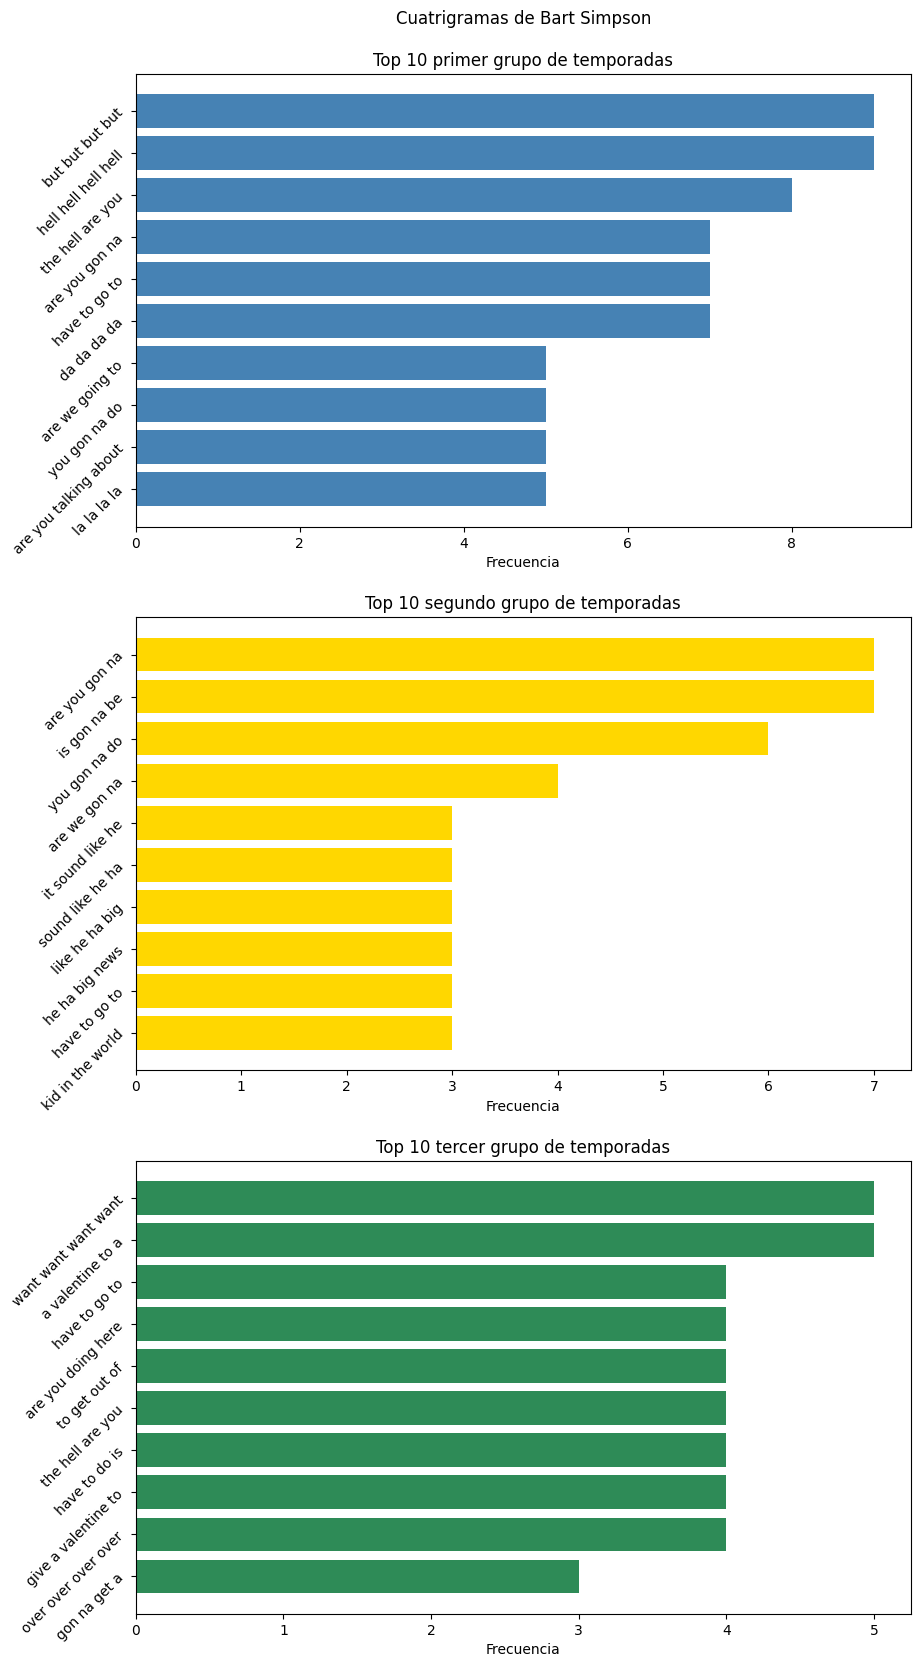

In [38]:
plt.figure(figsize=(10, 20))

plt.title('Cuatrigramas de Bart Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(cuatrigrams_sg1_bs)), counts_sg1_bs, tick_label=cuatrigrams_sg1_bs, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(cuatrigrams_sg2_bs)), counts_sg2_bs, tick_label=cuatrigrams_sg2_bs, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(cuatrigrams_sg3_bs)), counts_sg3_bs, tick_label=cuatrigrams_sg3_bs, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

### Para Lisa Simpson

In [39]:
df_scripts_sg1_ls = df_scripts[(df_scripts['season_group'] == 1) & (df_scripts['character_id'] == 9.0)]
df_scripts_sg2_ls = df_scripts[(df_scripts['season_group'] == 2) & (df_scripts['character_id'] == 9.0)]
df_scripts_sg3_ls = df_scripts[(df_scripts['season_group'] == 3) & (df_scripts['character_id'] == 9.0)]

# Grupo temporadas 1
all_bigrams_sg1_ls = [bigram for sublist in df_scripts_sg1_ls['bigrams'] for bigram in sublist]
bigram_counts_sg1_ls = Counter(all_bigrams_sg1_ls)
top_bigrams_sg1_ls = bigram_counts_sg1_ls.most_common(20)
bigrams_sg1_ls, counts_sg1_ls = zip(*top_bigrams_sg1_ls)

# Grupo temporadas 2
all_bigrams_sg2_ls = [bigram for sublist in df_scripts_sg2_ls['bigrams'] for bigram in sublist]
bigram_counts_sg2_ls = Counter(all_bigrams_sg2_ls)
top_bigrams_sg2_ls = bigram_counts_sg2_ls.most_common(20)
bigrams_sg2_ls, counts_sg2_ls = zip(*top_bigrams_sg2_ls)


# Grupo temporadas 3
all_bigrams_sg3_ls = [bigram for sublist in df_scripts_sg3_ls['bigrams'] for bigram in sublist]
bigram_counts_sg3_ls = Counter(all_bigrams_sg3_ls)
top_bigrams_sg3_ls = bigram_counts_sg3_ls.most_common(20)
bigrams_sg3_ls, counts_sg3_ls = zip(*top_bigrams_sg3_ls)


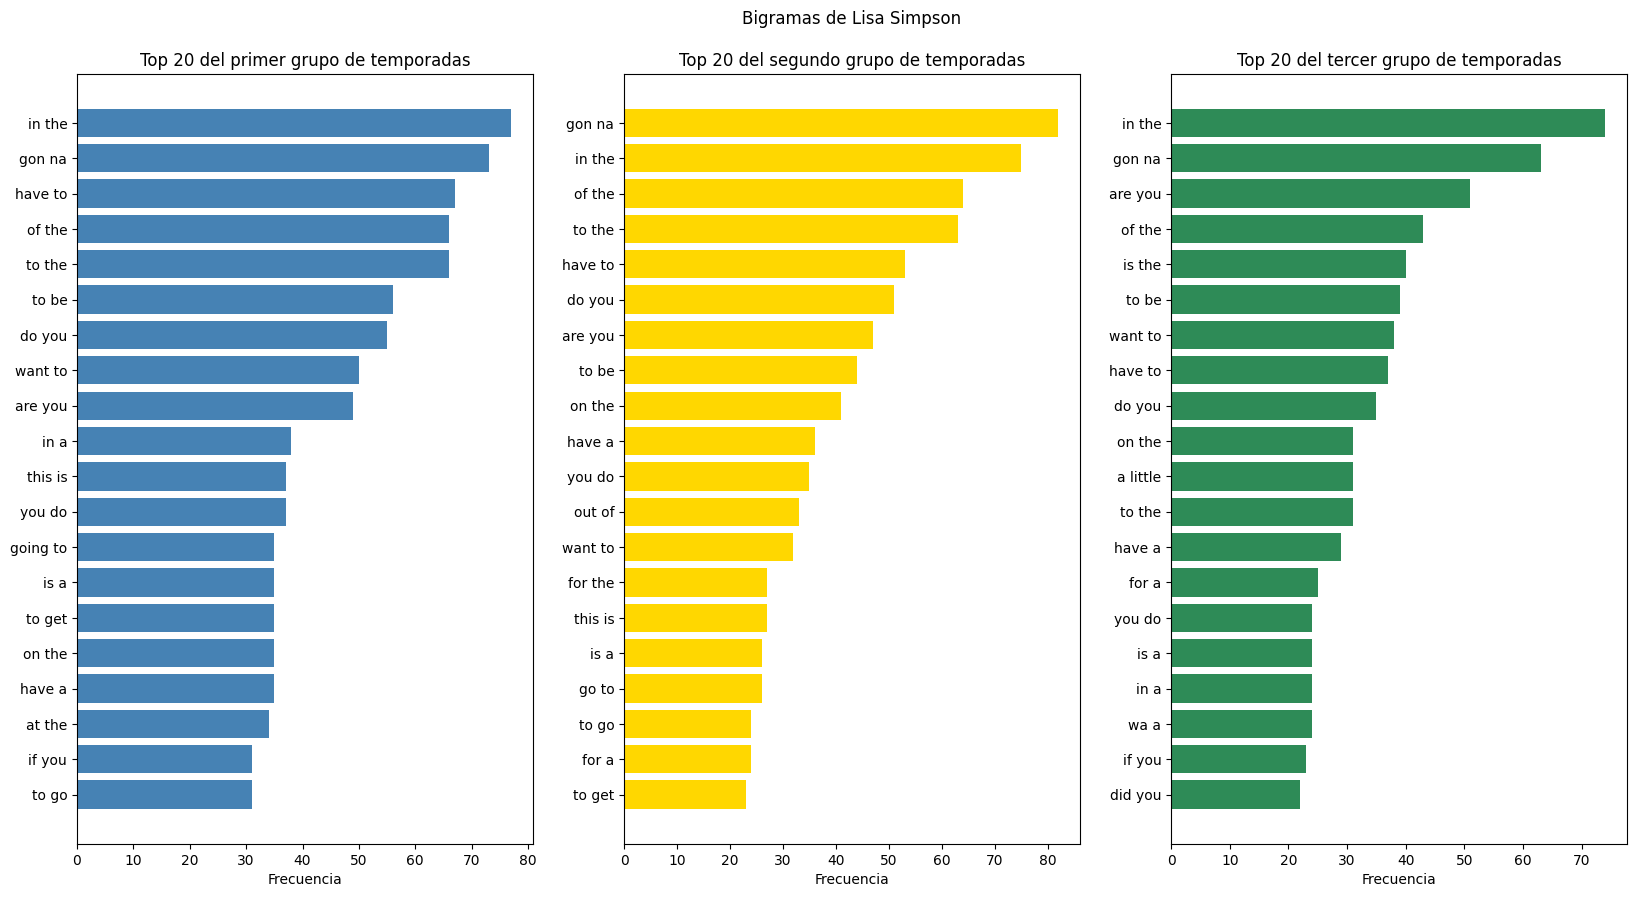

In [40]:
plt.figure(figsize=(20, 10))

plt.title('Bigramas de Lisa Simpson\n\n')
plt.axis('off')

plt.subplot(1, 3, 1)
plt.barh(range(len(bigrams_sg1_ls)), counts_sg1_ls, tick_label=bigrams_sg1_ls, color='#4682B4')
plt.xlabel('Frecuencia')
plt.title('Top 20 del primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 2)
plt.barh(range(len(bigrams_sg2_ls)), counts_sg2_ls, tick_label=bigrams_sg2_ls, color='#FFD700')
plt.xlabel('Frecuencia')
plt.title('Top 20 del segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(1, 3, 3)
plt.barh(range(len(bigrams_sg3_ls)), counts_sg3_ls, tick_label=bigrams_sg3_ls, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.title('Top 20 del tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [41]:
# Grupo temporadas 1
all_trigrams_sg1_ls = [trigram for sublist in df_scripts_sg1_ls['trigrams'] for trigram in sublist]
trigram_counts_sg1_ls = Counter(all_trigrams_sg1_ls)
top_trigrams_sg1_ls = trigram_counts_sg1_ls.most_common(10)
trigrams_sg1_ls, counts_sg1_ls = zip(*top_trigrams_sg1_ls)

# Grupo temporadas 2
all_trigrams_sg2_ls = [trigram for sublist in df_scripts_sg2_ls['trigrams'] for trigram in sublist]
trigram_counts_sg2_ls = Counter(all_trigrams_sg2_ls)
top_trigrams_sg2_ls = trigram_counts_sg2_ls.most_common(10)
trigrams_sg2_ls, counts_sg2_ls = zip(*top_trigrams_sg2_ls)


# Grupo temporadas 3
all_trigrams_sg3_ls = [trigram for sublist in df_scripts_sg3_ls['trigrams'] for trigram in sublist]
trigram_counts_sg3_ls = Counter(all_trigrams_sg3_ls)
top_trigrams_sg3_ls = trigram_counts_sg3_ls.most_common(10)
trigrams_sg3_ls, counts_sg3_ls = zip(*top_trigrams_sg3_ls)


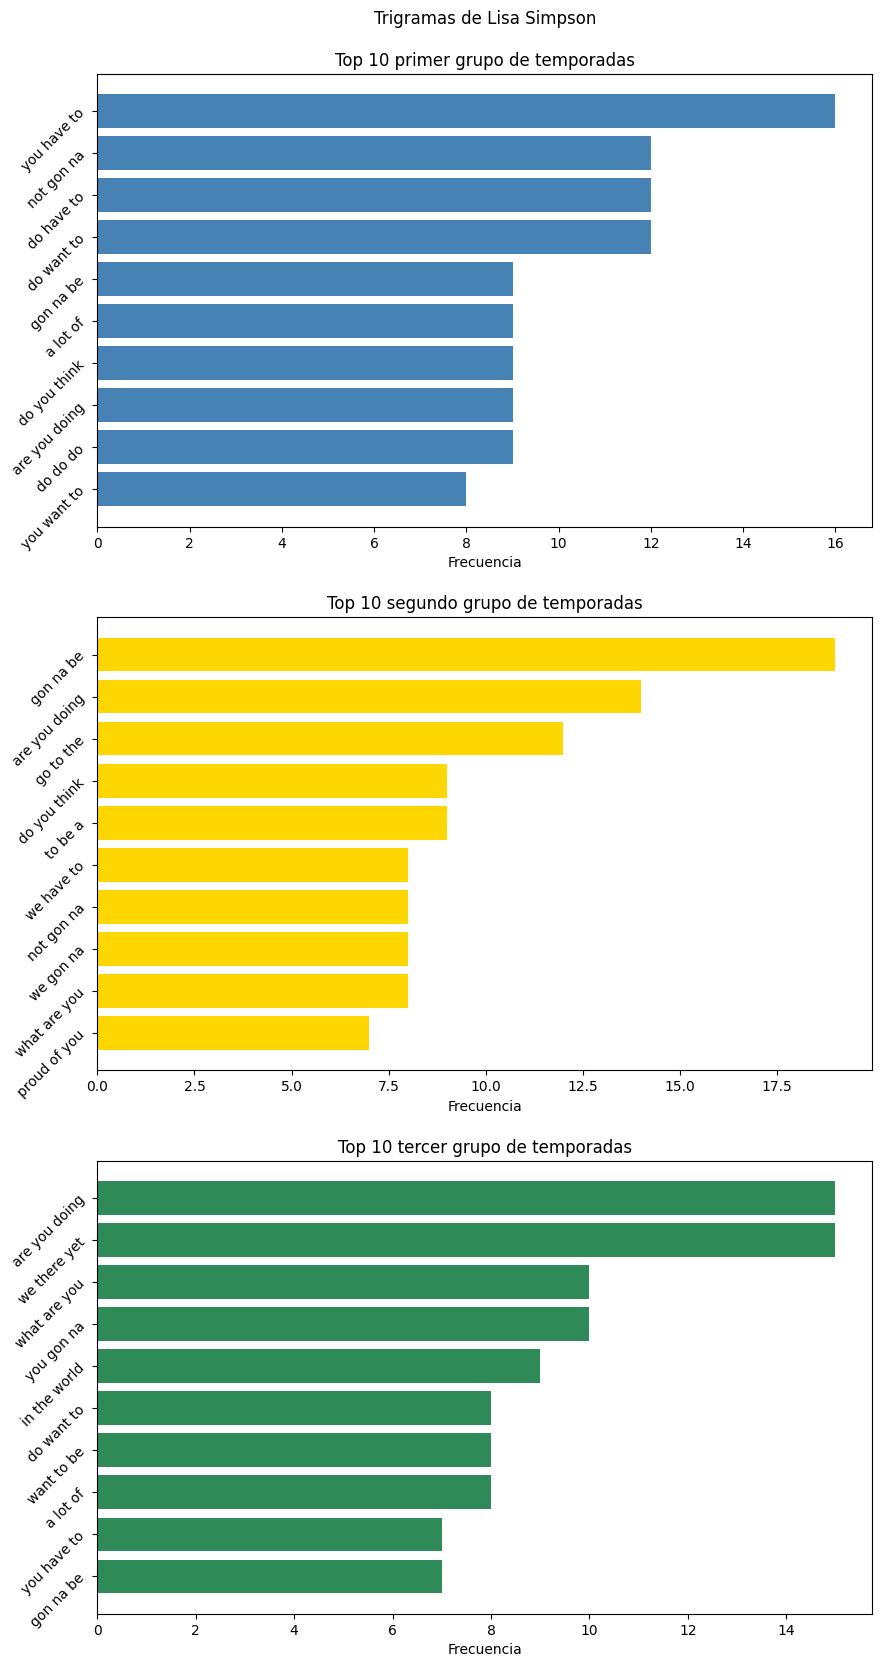

In [42]:
plt.figure(figsize=(10, 20))

plt.title('Trigramas de Lisa Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(trigrams_sg1_ls)), counts_sg1_ls, tick_label=trigrams_sg1_ls, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(trigrams_sg2_ls)), counts_sg2_ls, tick_label=trigrams_sg2_ls, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(trigrams_sg3_ls)), counts_sg3_ls, tick_label=trigrams_sg3_ls, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()

In [43]:
# Grupo temporadas 1
all_cuatrigrams_sg1_ls = [cuatrigram for sublist in df_scripts_sg1_ls['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg1_ls = Counter(all_cuatrigrams_sg1_ls)
top_cuatrigrams_sg1_ls = cuatrigram_counts_sg1_ls.most_common(10)
cuatrigrams_sg1_ls, counts_sg1_ls = zip(*top_cuatrigrams_sg1_ls)

# Grupo temporadas 2
all_cuatrigrams_sg2_ls = [cuatrigram for sublist in df_scripts_sg2_ls['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg2_ls = Counter(all_cuatrigrams_sg2_ls)
top_cuatrigrams_sg2_ls = cuatrigram_counts_sg2_ls.most_common(10)
cuatrigrams_sg2_ls, counts_sg2_ls = zip(*top_cuatrigrams_sg2_ls)


# Grupo temporadas 3
all_cuatrigrams_sg3_ls = [cuatrigram for sublist in df_scripts_sg3_ls['cuatrigrams'] for cuatrigram in sublist]
cuatrigram_counts_sg3_ls = Counter(all_cuatrigrams_sg3_ls)
top_cuatrigrams_sg3_ls = cuatrigram_counts_sg3_ls.most_common(10)
cuatrigrams_sg3_ls, counts_sg3_ls = zip(*top_cuatrigrams_sg3_ls)


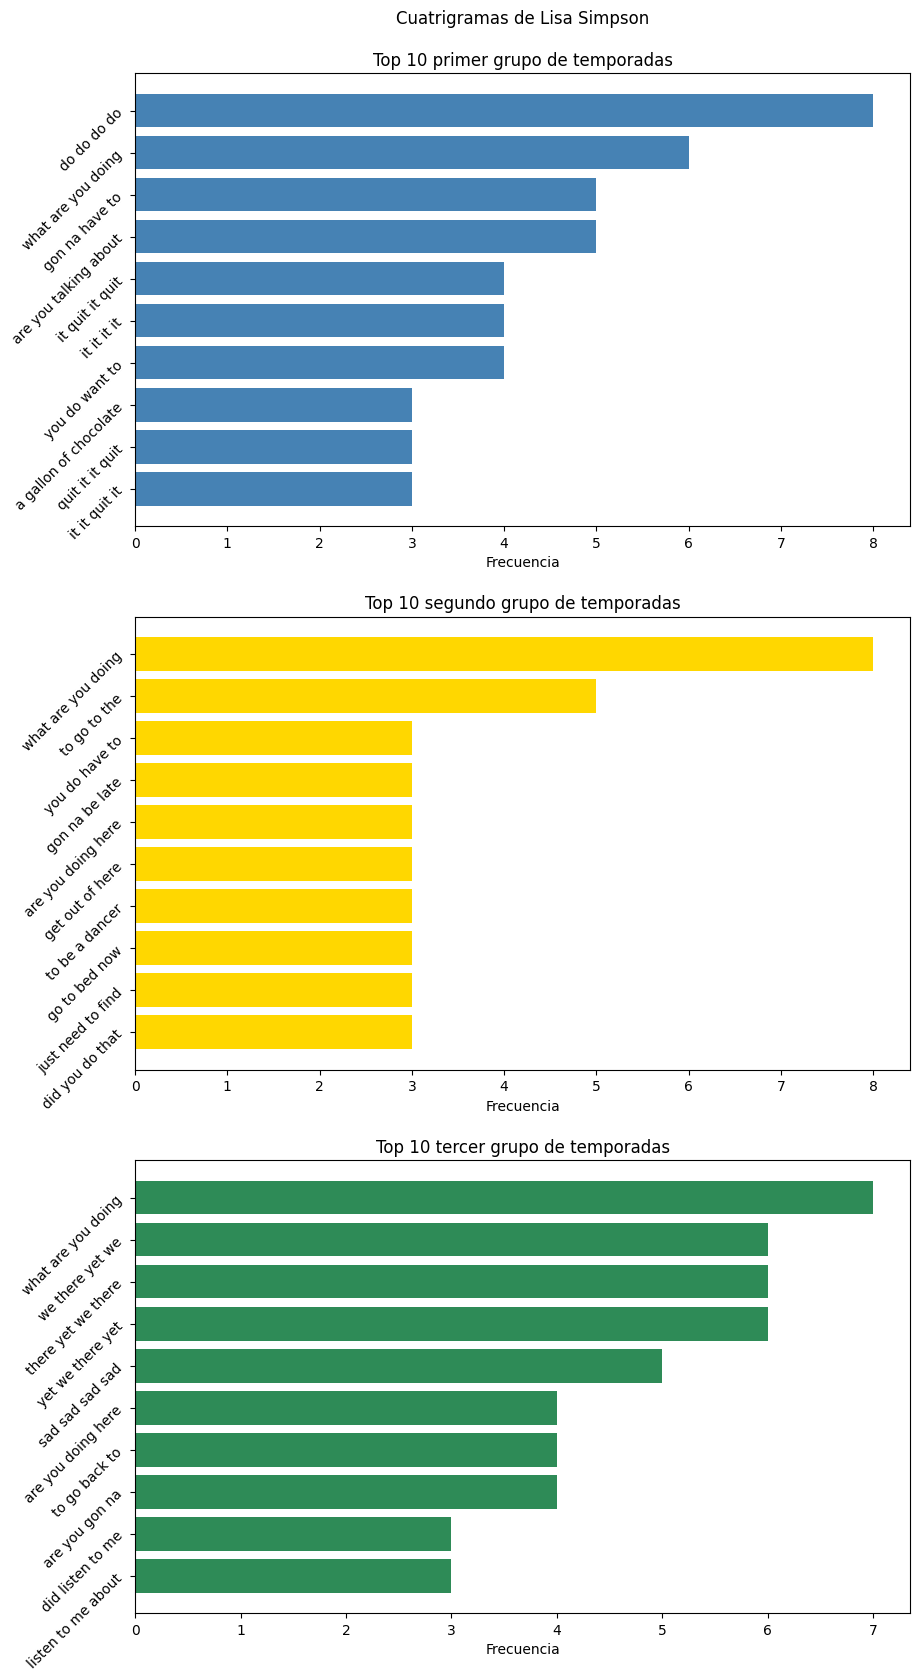

In [44]:
plt.figure(figsize=(10, 20))

plt.title('Cuatrigramas de Lisa Simpson\n\n')
plt.axis('off')


plt.subplot(3, 1, 1)
plt.barh(range(len(cuatrigrams_sg1_ls)), counts_sg1_ls, tick_label=cuatrigrams_sg1_ls, color='#4682B4')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 primer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 2)
plt.barh(range(len(cuatrigrams_sg2_ls)), counts_sg2_ls, tick_label=cuatrigrams_sg2_ls, color='#FFD700')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 segundo grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.subplot(3, 1, 3)
plt.barh(range(len(cuatrigrams_sg3_ls)), counts_sg3_ls, tick_label=cuatrigrams_sg3_ls, color='#2E8B57')
plt.xlabel('Frecuencia')
plt.yticks(rotation=45)
plt.title('Top 10 tercer grupo de temporadas')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top


plt.show()